# Exploratory analysis for federal contractors

This is just a simple exploratory analysis to get familiar with the Python language, docker containers, and Jupyter notebooks.  I've downloaded datasets from the [Federal Contractors Database](https://www.usaspending.gov/#/download_center/custom_award_data). For variable types, see the [data dictionary](http://fedspendingtransparency.github.io/dictionary-v1.1/).

[Track progress of the project on my trello board](https://trello.com/b/lZYSGp4M/federal-contractors-python)


While the goal is simply to get used to Python and some other technologies, I am interested in the specific question of ***what factors are the best predictors of minority owned companies***.  

#### Init
Read in the data and load packages

In [1]:
import pandas as pd
import numpy as np

dat = pd.read_csv('data/2017.csv', low_memory=False)

## Correlation Matrix

In [2]:
cmt = dat.corr()

I'm mostly interested in dollars the companies recieve and the size of the company. So I'm going to make a function that checks for a certain level of correlation for the selected variable. The following cells look at:  

* Dollars Obligated
* Number of Employees
* Minority Owned Flag

In [3]:
def corMat(dd, corlv, var):
    ind = abs(dd[var]) > corlv
    return dd.loc[ind, ind]; 

In [4]:
corMat(cmt,0.05, "dollarsobligated").dollarsobligated

dollarsobligated                         1.000000
baseandexercisedoptionsvalue             0.967203
baseandalloptionsvalue                   0.861076
progsourcesubacct                       -0.076980
prime_awardee_executive1_compensation   -0.084980
prime_awardee_executive2_compensation   -0.072067
prime_awardee_executive3_compensation   -0.071098
prime_awardee_executive4_compensation   -0.071617
prime_awardee_executive5_compensation   -0.065659
Name: dollarsobligated, dtype: float64

In [5]:
corMat(cmt,0.05, "numberofemployees").numberofemployees

progsourceagency                             -0.068632
progsourcesubacct                            -0.112453
ccrexception                                 -0.357217
vendor_cd                                     0.093742
congressionaldistrict                         0.093742
placeofperformancezipcode                    -0.145658
transactionnumber                             0.100897
numberofemployees                             1.000000
veteranownedflag                             -0.077613
receivescontracts                             0.077046
issubchapterscorporation                     -0.124280
islimitedliabilitycorporation                 0.051856
ispartnershiporlimitedliabilitypartnership    0.057622
prime_awardee_executive1_compensation         0.975024
prime_awardee_executive2_compensation         0.980690
prime_awardee_executive3_compensation         0.972878
prime_awardee_executive4_compensation         0.963208
prime_awardee_executive5_compensation         0.973902
Name: numb

In [6]:
corMat(cmt,0.25, "minorityownedbusinessflag").minorityownedbusinessflag

progsourcesubacct                               -0.288274
placeofperformancezipcode                        0.255004
firm8aflag                                       0.316287
minorityownedbusinessflag                        1.000000
apaobflag                                        0.614026
baobflag                                         0.329557
naobflag                                         0.263247
haobflag                                         0.269490
isdotcertifieddisadvantagedbusinessenterprise    0.270052
prime_awardee_executive1_compensation           -0.337572
prime_awardee_executive2_compensation           -0.375064
prime_awardee_executive3_compensation           -0.398767
prime_awardee_executive4_compensation           -0.446047
prime_awardee_executive5_compensation           -0.400471
Name: minorityownedbusinessflag, dtype: float64

The minority owned business flag shows several interesting correlations:  

1. apaobflag, baobflag, naobflag, and haobflag are just subtypes of minority flags: Asian Pacific American, Black American, Native American, and Hispanic American, respectively. (Thus they're not particularly interesting. 
2. firm8aflag is for 8(a) Program Participant Organizations, which is a program for small, underpriviledged companies. 
3. DOT certified disadvantaged companies has a slightly smaller correlation. 
4. All ofthe executive compensations have a negative correlation, meaning that as executive compensation goes up, the likelihood of being minority owned is smaller.

## Aggregation

I need to aggregate the awards based on company. Some companies have a lot of awards, so it could mess with things.  I'm also interested in adding a column that shows the count of awards for companies since that might be a good predictor of minority owned businesses. 

My hunch is that minority owned businesses are smaller than average, and have lower executive compensation/annual revenue than average. 

In [7]:
# sum of dollars obligated
grp = ['vendorname', 'minorityownedbusinessflag']
aggDollars = dat.groupby(grp)[['dollarsobligated']].agg(['sum', 'mean','count'])
aggDolalrs = aggDollars.reset_index(1)

# mean of prime_awardee_executive1_compensation
aggExec = dat.groupby(grp)[['prime_awardee_executive1_compensation']].agg(['mean'])

# mean employeenumber
aggEmps = dat.groupby(grp)[['numberofemployees']].agg(['median'])

In [8]:
# Now join the three data sets
aggs = pd.merge(aggDollars, aggEmps, on=['vendorname', 'minorityownedbusinessflag'])
#aggs = pd.merge(aggs, aggExec, on=['vendorname', 'minorityownedbusinessflag'])

In [9]:
aggs.reset_index(level=1, inplace=True)
min_counts = aggs['minorityownedbusinessflag'].value_counts()
print(min_counts)
min_counts[1]/min_counts.sum()

False    3155
True      296
Name: minorityownedbusinessflag, dtype: int64


0.08577223993045494

In [10]:
aggs.columns.get_level_values(0)
aggs.columns = aggs.columns.droplevel(0)
aggs.head()

,,sum,mean,count,median
vendorname,,,,,
"1872 FORCE PROTECTION, LLC",True,1355532.43,1.355532e+06,1,10.0
"1ST CHOICE APPRAISAL SERVICES, LLC",False,1750.00,4.375000e+02,4,1.0
2001 SIXTH LLC,False,-855.22,-8.552200e+02,1,24.0
3 D CONTRACTING INC.,False,58157.68,1.938589e+04,3,8.0
"3 R RESOURCES, INC.",False,35204.74,5.029249e+03,7,2.0


There is clearly something going on with the number of employees. I'll treat that as a caveat for now. I can't really use it, but this is all just a use case for me to get familiar with python. 

I could scrub the SEC website to find all company CIK numbers (only for publicly traded ones), then scrub through all of their 10-k forms to find their employee counts as of 12/30/2017...but that's a lot of web scraping at this stage. 

Instead, I'm going to bucket the companies by employee count size. That way I can just say that any company with more than 500,000 employees is in the largest group. 

SEC had Cingular Wireless with [65,000 employees in 2005](https://www.sec.gov/Archives/edgar/data/1130452/000095014406001479/g99532e10vk.htm). This says 304,000 (median) in 2017. [AT&T has 268,000 employees](https://www.sec.gov/Archives/edgar/data/732717/000073271717000021/ye16_10k.htm), so maybe that's what's going on.  

With that said, [Boeing is correct](https://www.sec.gov/Archives/edgar/data/12927/000001292717000006/a201612dec3110k.htm).

## Assigning Buckets to Employee Count

In [11]:
# assign buckets to employee count

## Add Rural/Urban flag

This dataset includes zip codes and address, but that's not good as a categorical variable. I'd like to create one, but I'm going to have to figure out the best way to do it. On other projects I've had to look up population statistics from the US Census, then join those in based on FIPS codes. We'll see if that's necessary here. 

The US Census Bureau [provides definitions of urban and rural zip codes.](https://www.census.gov/geo/reference/urban-rural.html)


### FInal Data Selection:
(note, I should probably do a more nuanced feature selection method, like Recursive Feature Elimination)

In [12]:
fed = aggs
fed.columns = ['minorityowned', 'total_dollars', 'mean_dollars', 
               'count_record', 'median_emps']
fed = fed.reset_index(drop=True)

## Logistic Regression

I'd like to do a logistic regression for a few of the variables above to see if they predict minority owned business


In [13]:
X = fed.loc[:, fed.columns != 'minorityowned']
y = fed.loc[:, fed.columns == 'minorityowned']

It looks like our features aren't great predictors of minority owned businesses.  Only the average dollars per record and the median number of employees per record for each company has any predictive power.

With that said, it looks like there is an overflow problem with the float64 variables, which is likely converting larger values for each of our predictors into NaN. To handle this, X should be normalized.

In [14]:
import statsmodels.api as sm
logit_model=sm.Logit(y,X)

result=logit_model.fit()
print(result.summary2())

Optimization terminated successfully.
         Current function value: 0.503508
         Iterations 15
                         Results: Logit
Model:              Logit            Pseudo R-squared: -0.721   
Dependent Variable: minorityowned    AIC:              3483.2113
Date:               2018-09-29 06:17 BIC:              3507.7970
No. Observations:   3451             Log-Likelihood:   -1737.6  
Df Model:           3                LL-Null:          -1009.9  
Df Residuals:       3447             LLR p-value:      1.0000   
Converged:          1.0000           Scale:            1.0000   
No. Iterations:     15.0000                                     
----------------------------------------------------------------
                 Coef.  Std.Err.    z     P>|z|   [0.025  0.975]
----------------------------------------------------------------
total_dollars    0.0000   0.0000   1.8375 0.0661 -0.0000  0.0000
mean_dollars    -0.0000   0.0000  -4.6075 0.0000 -0.0000 -0.0000
count_record

/opt/conda/lib/python3.6/site-packages/statsmodels/discrete/discrete_model.py:1674: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))


In this case, the model performance is even worse: once the model is normalized, none of the predictors have a significant P-value.

In [15]:
#X_norm = (X - X.min())/(X.max()-X.min())
from sklearn.preprocessing import scale
X_scl = scale(X) #X_scl = (X- X.mean())/X.std()


logit_nrm=sm.Logit(y,X_scl)

result=logit_nrm.fit()
print(result.summary2())

Optimization terminated successfully.
         Current function value: 0.693083
         Iterations 5
                         Results: Logit
Model:              Logit            Pseudo R-squared: -1.368   
Dependent Variable: minorityowned    AIC:              4791.6612
Date:               2018-09-29 06:17 BIC:              4816.2468
No. Observations:   3451             Log-Likelihood:   -2391.8  
Df Model:           3                LL-Null:          -1009.9  
Df Residuals:       3447             LLR p-value:      1.0000   
Converged:          1.0000           Scale:            1.0000   
No. Iterations:     5.0000                                      
-------------------------------------------------------------------
       Coef.     Std.Err.       z       P>|z|      [0.025    0.975]
-------------------------------------------------------------------
x1    -0.0047      0.0372    -0.1264    0.8994    -0.0776    0.0682
x2    -0.0044      0.0364    -0.1197    0.9047    -0.0756    0.066

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:3: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by the scale function.
  This is separate from the ipykernel package so we can avoid doing imports until


This may be because the minority owned businesses are an imbalanced classifier. Note from above that the minority owned flag appears in only 8.58% of the companies in the data set. To handle this we must select a resampling method.

## Resampling

I'm going to try random undersampling. It might work to use a more nuanced method, but this resampling method is easier to interpret. Since the data set is small, I'll probably want to change to random oversampling or SMOTE. 

(I actually tried smote originally, hence 'X_sm' and 'y_sm'. The 2-d representation plot is much nicer with undersampling, so I'm keeping it for now.)

It seemed like I got the best result with [Over-sampling followed by under-sampling](https://www.kaggle.com/rafjaa/resampling-strategies-for-imbalanced-datasets), but I want to leave undersampling for readability in the plot for now. 

In [16]:
from imblearn.under_sampling import RandomUnderSampler
rus = RandomUnderSampler(return_indices=True, random_state=22)

X_sm, y_sm, id_rus = rus.fit_sample(X_scl, y.values.ravel())
#print(X_ros.shape[0] - X_norm.shape[0], 'new random picked points')

Still no luck with random over sampling and normalization. It seems from this like reduction in median employee count does predict minority owned business, but there is such a low R-squared and hight AIC that it's not going to be much value for prediction.

In [17]:
logit_sm = sm.Logit(y_sm,X_sm)

result = logit_sm.fit()
print(result.summary2())

Optimization terminated successfully.
         Current function value: 0.665282
         Iterations 11
                         Results: Logit
Model:              Logit            Pseudo R-squared: 0.040     
Dependent Variable: y                AIC:              795.6935  
Date:               2018-09-29 06:17 BIC:              813.2275  
No. Observations:   592              Log-Likelihood:   -393.85   
Df Model:           3                LL-Null:          -410.34   
Df Residuals:       588              LLR p-value:      3.2320e-07
Converged:          1.0000           Scale:            1.0000    
No. Iterations:     11.0000                                      
-------------------------------------------------------------------
         Coef.     Std.Err.      z      P>|z|     [0.025     0.975]
-------------------------------------------------------------------
x1       25.3027     7.8169    3.2369   0.0012     9.9819   40.6235
x2       -0.4017     0.1509   -2.6628   0.0077    -0.6974

In [20]:
import matplotlib
import matplotlib.pyplot as plt
def plot_2d_space(X, y, label='Classes'):   
    colors = ['#1F77B4', '#FF7F0E']
    markers = ['o', 's']
    for l, c, m in zip(np.unique(y), colors, markers):
        plt.scatter(
            X[y==l, 0],
            X[y==l, 1],
            c=c, label=l, marker=m
        )
    plt.title(label)
    plt.legend(loc='upper right')
    plt.show()


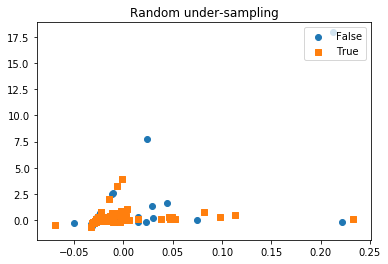

In [21]:
plot_2d_space(X_sm, y_sm, 'Random under-sampling')

### Test & Train Split

This is just to practice implementing a model in Python. I'm going to have to change this all out once we've got a model that's working.

In [22]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_sm, y_sm, test_size = .4,
                                                   random_state=42)

from sklearn import linear_model as lm
classifier = lm.LogisticRegression(random_state=22, solver='lbfgs',
                               multi_class='multinomial')

classifier.fit(X_train, y_train)

predictions = classifier.predict(X_test)

from sklearn.metrics import accuracy_score
acc_score = accuracy_score(y_test, predictions)
print('Accuracy of logistic regression classifier on test set: {:.2f}'.format(acc_score))

Accuracy of logistic regression classifier on test set: 0.53


In [23]:
from sklearn.metrics import confusion_matrix
confusion_matrix = confusion_matrix(y_test, predictions)
print(confusion_matrix)

[[ 13 110]
 [  1 113]]


In [24]:
df = pd.DataFrame(y_test, predictions).reset_index(0)
df.columns = ['lables', 'preds']
df

,lables,preds
0,True,True
1,True,True
2,True,False
3,False,False
4,True,True
5,True,False
6,True,True
7,True,True
8,True,False
9,True,True


In [25]:
from sklearn.metrics import classification_report
print(classification_report(y_test, predictions))

              precision    recall  f1-score   support

       False       0.93      0.11      0.19       123
        True       0.51      0.99      0.67       114

   micro avg       0.53      0.53      0.53       237
   macro avg       0.72      0.55      0.43       237
weighted avg       0.73      0.53      0.42       237



#### Why I have a feature generation branch!

I'll add a resampling_method branch as well. 

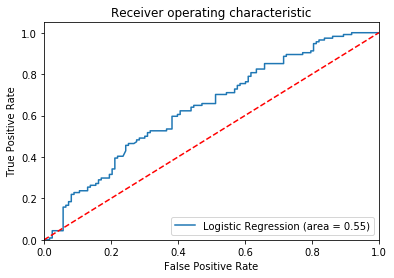

In [26]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
%matplotlib inline  
logit_roc_auc = roc_auc_score(y_test, classifier.predict(X_test))
fpr, tpr, thresholds = roc_curve(y_test, classifier.predict_proba(X_test)[:,1])
plt.figure()
plt.plot(fpr, tpr, label='Logistic Regression (area = %0.2f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig('figs/Log_ROC')
plt.show()